# Lecture 8. Transformers

**Maybe attention is all you need**

Joaquin Vanschoren

In [24]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots 
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)
    
HTML('''<style>.rise-enabled .reveal pre {font-size=75%} </style>''')

## Overview
* Basics: word embeddings
    * Word2Vec, FastText, GloVe
* Sequence-to-sequence and autoregressive models
* Self-attention and transformer models
* Vision Transformers

## Bag of word representation
* First, build a _vocabulary_ of all occuring words. Maps every word to an index.
* Represent each document as an $N$ dimensional vector (top-$N$ most frequent words)
    * One-hot (sparse) encoding: 1 if the word occurs in the document
* Destroys the order of the words in the text (hence, a 'bag' of words)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/bag_of_words.png" alt="ml" style="width: 60%"/>

### Text preprocessing pipelines
* Tokenization: how to you split text into words / tokens?
* Stemming: naive reduction to word stems. E.g. 'the meeting' to 'the meet'
* Lemmatization: NLP-based reduction, e.g. distinguishes between nouns and verbs
* Discard stop words ('the', 'an',...)
* Only use $N$ (e.g. 10000) most frequent words, or a hash function
* n-grams: Use combinations of $n$ adjacent words next to individual words
    * e.g. 2-grams: "awesome movie", "movie with", "with creative", ...
* Character n-grams: combinations of $n$ adjacent letters: 'awe', 'wes', 'eso',...
* Subword tokenizers: graceful splits "unbelievability" -> un, believ, abil, ity
* Useful libraries: [nltk](https://www.nltk.org/), [spaCy](https://spacy.io/), [gensim](https://radimrehurek.com/gensim/), [HuggingFace tokenizers](https://huggingface.co/docs/tokenizers/index),...

### Scaling
* Only for classical models, LLMs use subword tokenizers and dense tokens from embedding layers (see later)
* L2 Normalization (vector norm): sum of squares of all word values equals 1
    * Normalized Euclidean distance is equivalent to cosine distance
    * Works better for distance-based models (e.g. kNN, SVM,...)
$$ t_i = \frac{t_i}{\| t\|_2 }$$

* Term Frequency - Inverted Document Frequency (TF-IDF)
    * Scales value of words by how frequently they occur across all $N$ documents
    * Words that only occur in few documents get higher weight, and vice versa

$$ t_i = t_i \cdot log(\frac{N}{|\{d \in D : t_i \in d\}|})$$

## Neural networks on bag of words
* We can build neural networks on bag-of-word vectors
    * Do a one-hot-encoding with 10000 most frequent words
    * Simple model with 2 dense layers, ReLU activation, dropout
    
``` python
self.model = nn.Sequential(
    nn.Linear(10000, 16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16, 1)
)
```

### Evaluation
* IMDB dataset of movie reviews (label is 'positive' or 'negative')
* Take a validation set of 10,000 samples from the training set
* Works prety well (88% Acc), but overfits easily

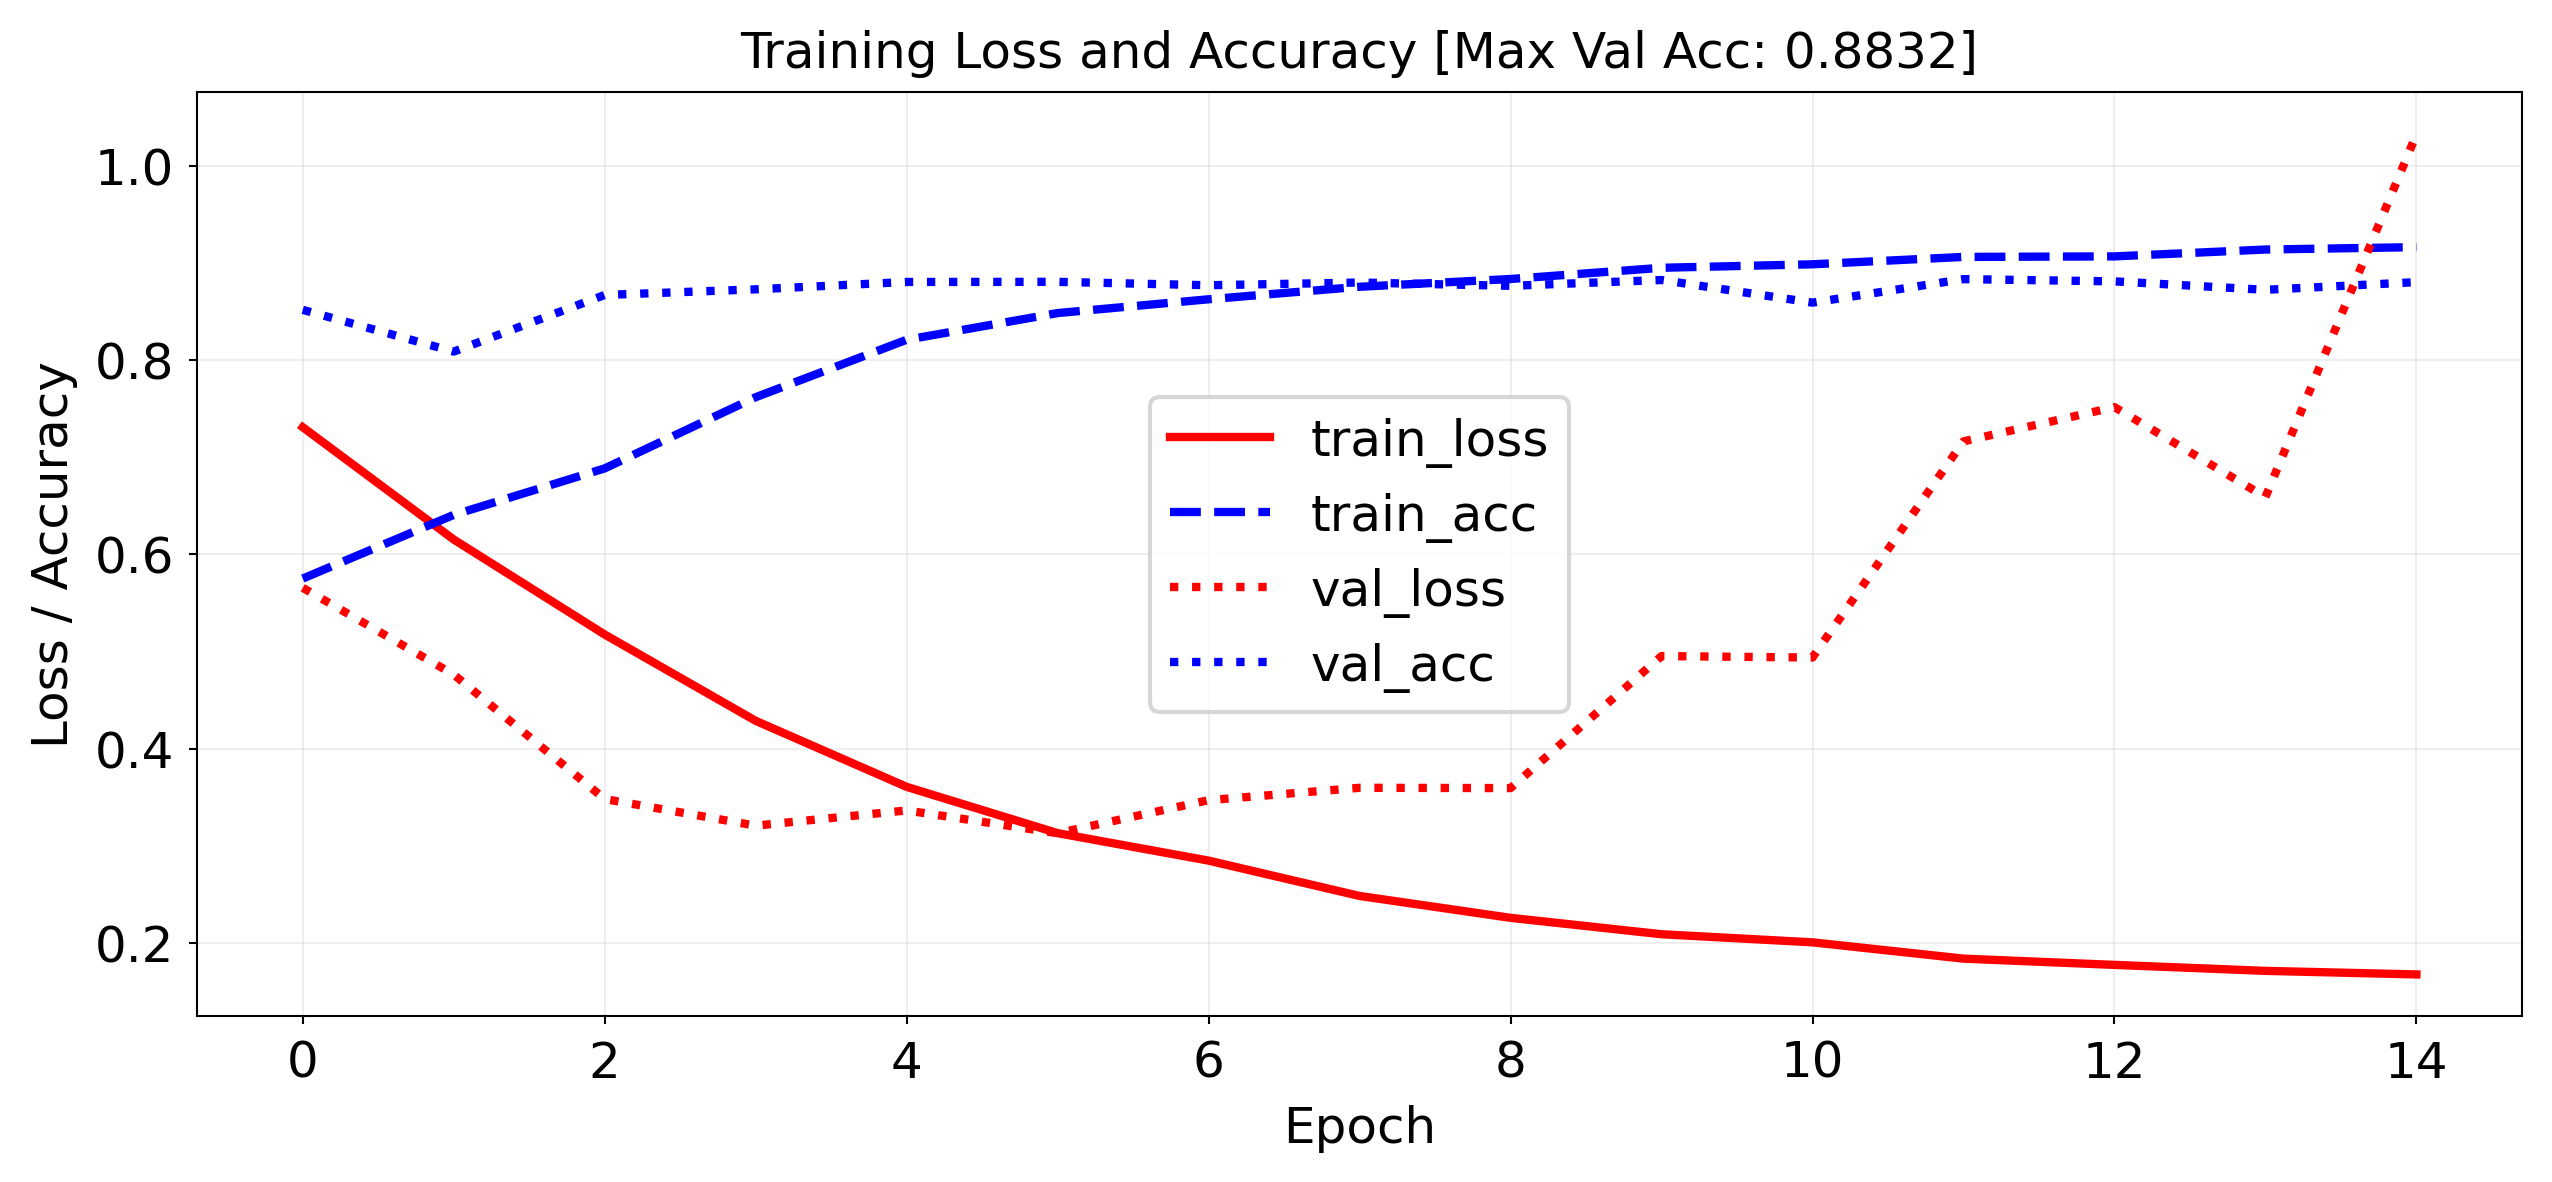

`Trainer.fit` stopped: `max_epochs=15` reached.


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from keras.datasets import imdb
from IPython.display import clear_output

# Load data with top 10,000 words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Vectorize sequences into one-hot encoded vectors
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

# One-hot encode
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

class IMDBVectorizedDataset(Dataset):
    def __init__(self, features, labels):
        self.x = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# Validation split like in Keras: first 10k for val
x_val, x_partial_train = x_train[:10000], x_train[10000:]
y_val, y_partial_train = y_train[:10000], y_train[10000:]

train_dataset = IMDBVectorizedDataset(x_partial_train, y_partial_train)
val_dataset = IMDBVectorizedDataset(x_val, y_val)
test_dataset = IMDBVectorizedDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

class LivePlotCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
        self.max_acc = 0

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics

        train_loss = metrics.get("train_loss")
        train_acc = metrics.get("train_acc")
        val_loss = metrics.get("val_loss")
        val_acc = metrics.get("val_acc")

        if all(v is not None for v in [train_loss, train_acc, val_loss, val_acc]):
            self.train_losses.append(train_loss.item())
            self.train_accs.append(train_acc.item())
            self.val_losses.append(val_loss.item())
            self.val_accs.append(val_acc.item())
            self.max_acc = max(self.max_acc, val_acc.item())

            if len(self.train_losses) > 1:
                clear_output(wait=True)
                N = np.arange(0, len(self.train_losses))
                plt.figure(figsize=(10, 4))
                plt.plot(N, self.train_losses, label='train_loss', lw=2, c='r')
                plt.plot(N, self.train_accs, label='train_acc', lw=2, c='b')
                plt.plot(N, self.val_losses, label='val_loss', lw=2, linestyle=":", c='r')
                plt.plot(N, self.val_accs, label='val_acc', lw=2, linestyle=":", c='b')
                plt.title(f"Training Loss and Accuracy [Max Val Acc: {self.max_acc:.4f}]", fontsize=12)
                plt.xlabel("Epoch", fontsize=12)
                plt.ylabel("Loss / Accuracy", fontsize=12)
                plt.tick_params(axis='both', labelsize=12)
                plt.legend(fontsize=12)
                plt.grid(True)
                plt.show()
            
class IMDBClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 16)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, 16)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.binary_cross_entropy(y_hat, y)
        val_acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", val_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters())
    
model = IMDBClassifier()
trainer = pl.Trainer(max_epochs=15, callbacks=[LivePlotCallback()], logger=False, enable_checkpointing=False)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)



#### Predictions
Let's look at a few predictions. Why is the last one so negative?

In [3]:
# 1. Get the trained model into eval mode
model.eval()

# 2. Disable gradient tracking
with torch.no_grad():
    # Convert entire test set to a tensor if not already
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Get predictions
    predictions = model(x_test_tensor).numpy()

# Get word index from Keras
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
reverse_word_index = {value: key for key, value in word_index.items()}

# Add special tokens
reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNUSED]'

def encode_review(text, word_index, num_words=10000):
    # Basic preprocessing
    words = text.lower().split()
    encoded = [1]  # 1 is the index for [START]

    for word in words:
        index = word_index.get(word, 2)  # 2 is [UNK]
        if index < num_words:
            encoded.append(index)
    return encoded

# Function to decode a review
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review])

print("Review 0:\n", decode_review(test_data[0]))
print("Predicted positiveness:", predictions[0])

print("\nReview 16:\n", decode_review(test_data[16]))
print("Predicted positiveness:", predictions[16])

# New sentence
sentence = '[START] this movie was not too terrible'
encoded = encode_review(sentence, word_index)
vectorized = vectorize_sequences([encoded])  # Note: wrap in list to get shape (1, 10000)
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(vectorized, dtype=torch.float32)
    prediction = model(input_tensor).item()

print("\nReview X:\n",sentence)
print(f"Predicted positiveness: {prediction:.4f}")

Review 0:
 [START] please give this one a miss br br [UNK] [UNK] and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite [UNK] so all you madison fans give this a miss
Predicted positiveness: 0.0010664713

Review 16:
 [START] from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem [UNK] he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone could make the movie lik

## Word Embeddings
* A word embedding is a numeric vector representation of a word
    * Can be manual or _learned_ from an existing representation (e.g. one-hot)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_embeddings.png" alt="ml" style="width: 60%; margin-left: auto; margin-right: auto;">

### Learning embeddings from scratch
* Input layer uses fixed length documents (with 0-padding).
* Add an _embedding layer_ to learn the embedding
    * Create $n$-dimensional one-hot encoding.
    * To learn an $m$-dimensional embedding, use $m$ hidden nodes. Weight matrix $W^{n x m}$
    * Linear activation function: $\mathbf{X}_{embed} = W \mathbf{X}_{orig}$.
* Combine all word embeddings into a document embedding (e.g. global pooling).
* Add layers to map word embeddings to the output. Learn embedding weights from data.


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_embedding_layer.png" alt="ml" style="width: 60%; margin-left: auto; margin-right: auto;">

Let's try this:

```python
max_length = 100 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 20 # embedding length (more would be better)

self.model = nn.Sequential(
    nn.Embedding(vocab_size, embedding_length),
    nn.AdaptiveAvgPool1d(1),  # global average pooling over sequence
    nn.Linear(embedding_length, 1),
)
```

* Training on the IMDB dataset: slightly worse than using bag-of-words?
    * Embedding of dim 20 is very small, should be closer to 100 (or 300)
    * We don't have enough data to learn a really good embedding from scratch


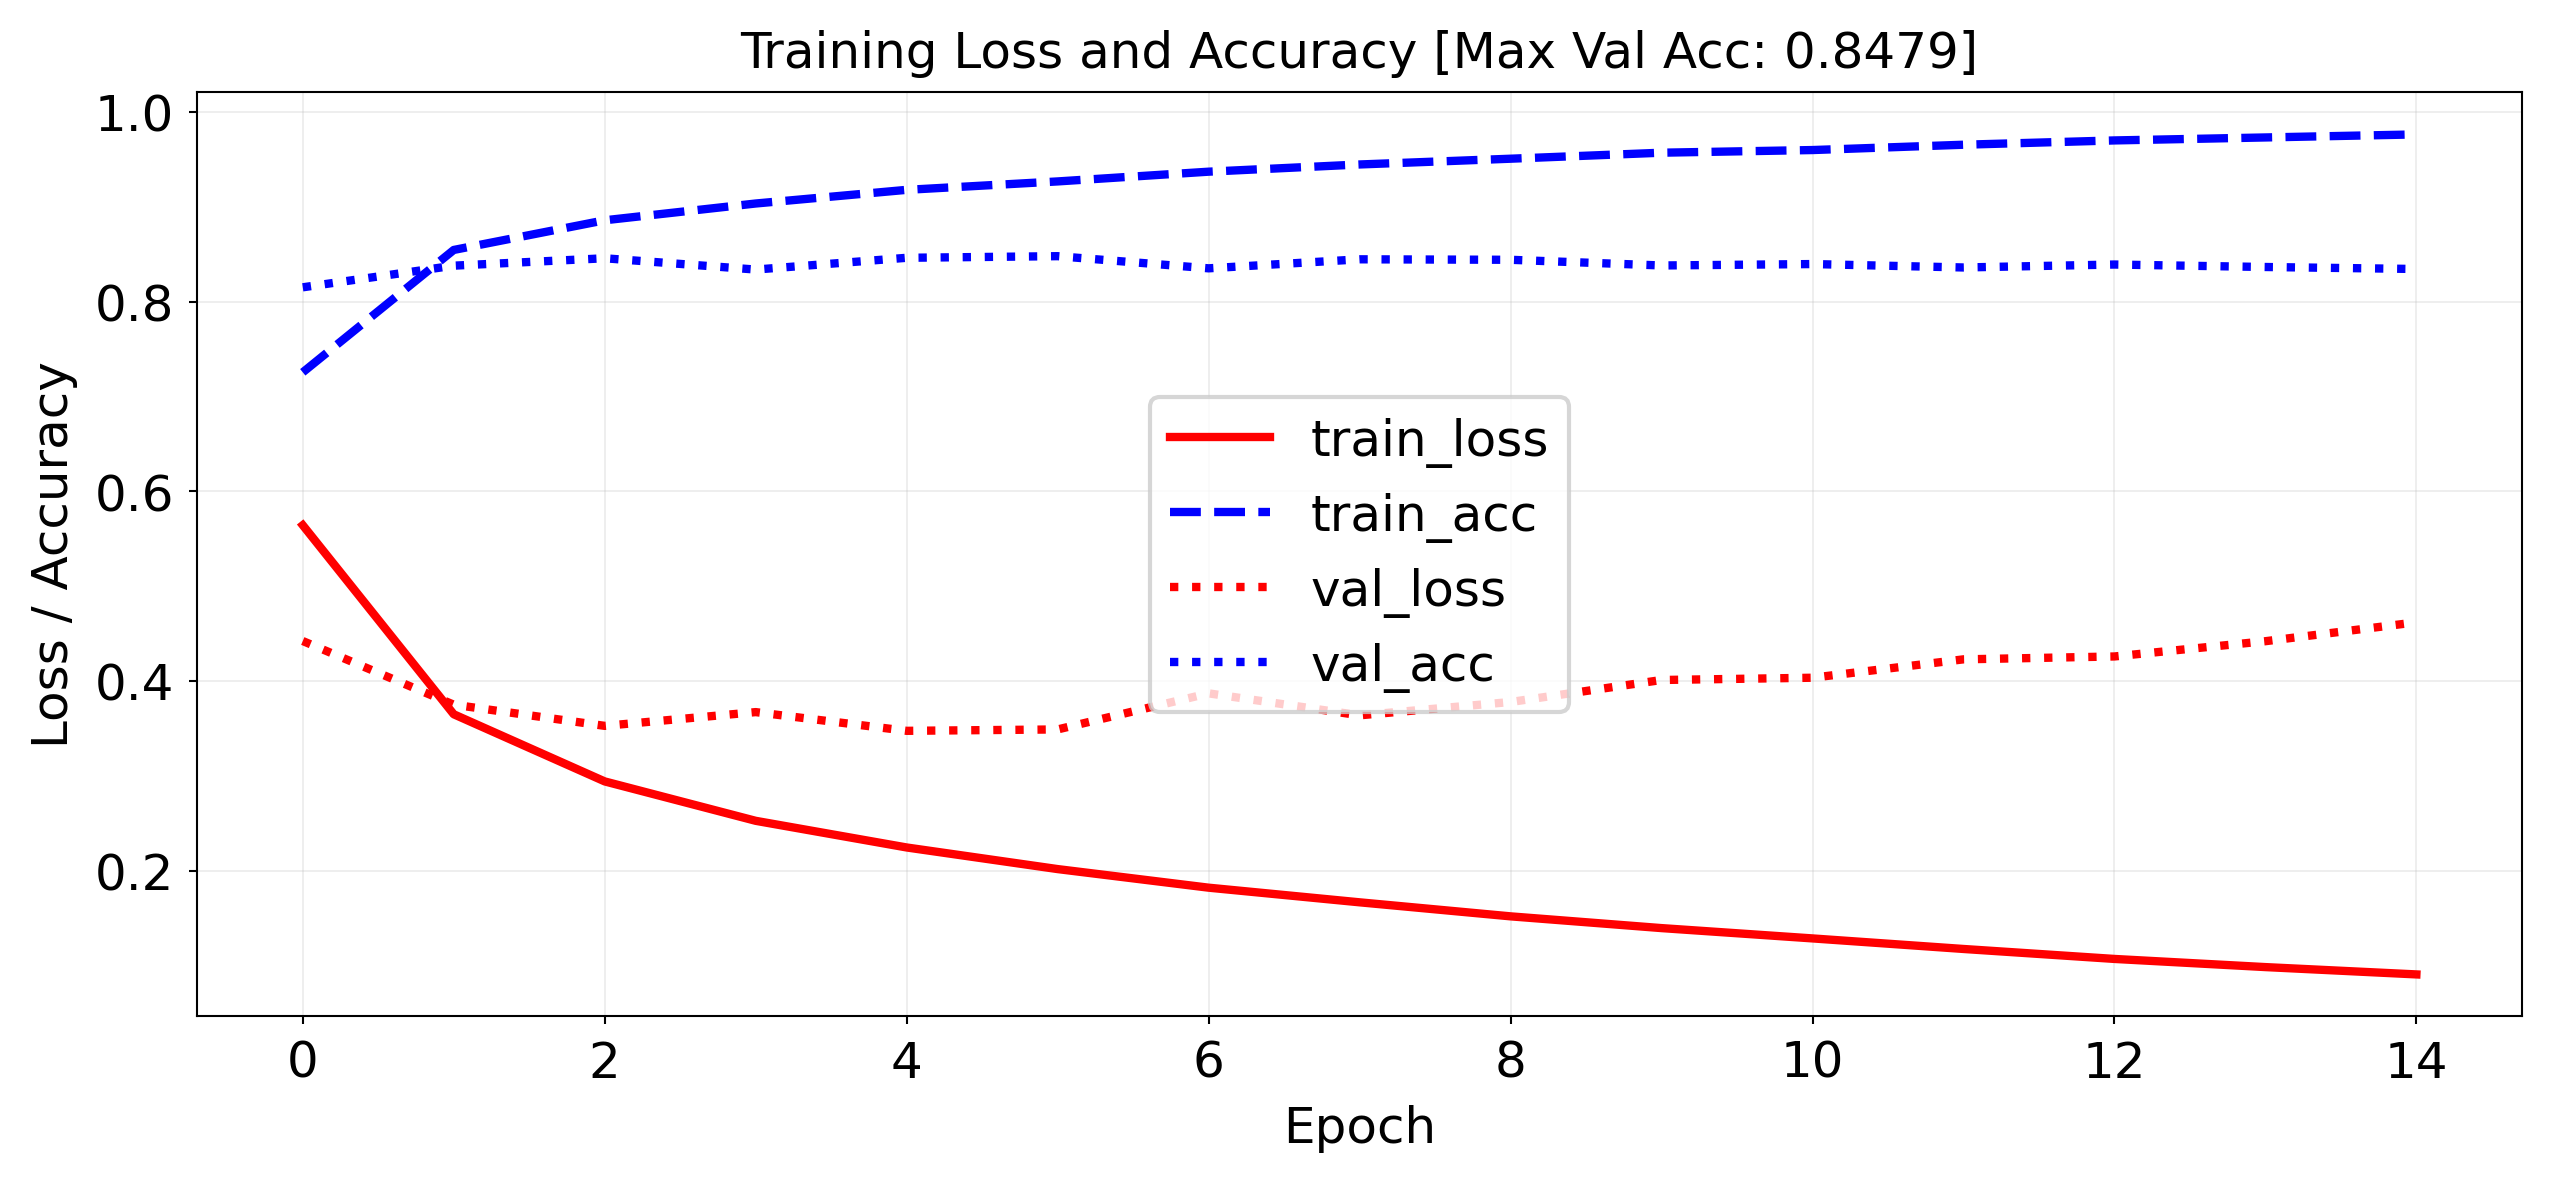

`Trainer.fit` stopped: `max_epochs=15` reached.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class IMDBVectorizedDataset(Dataset):
    def __init__(self, features, labels):
        self.x = torch.tensor(features, dtype=torch.long) # Needs long
        self.y = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class IMDBEmbeddingModel(pl.LightningModule):
    def __init__(self, vocab_size=10000, embedding_length=20, max_length=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_length)
        self.pooling = nn.AdaptiveAvgPool1d(1)  # GlobalAveragePooling1D equivalent
        self.fc = nn.Linear(embedding_length, 1)

    def forward(self, x):
        # x: (batch, max_length)
        embedded = self.embedding(x)  # (batch, max_length, embedding_length)
        embedded = embedded.permute(0, 2, 1)  # for AdaptiveAvgPool1d → (batch, embed_dim, seq_len)
        pooled = self.pooling(embedded).squeeze(-1)  # → (batch, embed_dim)
        output = torch.sigmoid(self.fc(pooled))  # → (batch, 1)
        return output.squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.binary_cross_entropy(y_hat, y)
        val_acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", val_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters())

# Build padded sequences
from keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000
max_length = 100

# Load and preprocess
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(train_data, maxlen=max_length)
x_test = pad_sequences(test_data, maxlen=max_length)

y_train = train_labels
y_test = test_labels

# Split training/validation like in Keras example
x_val, x_partial_train = x_train[:10000], x_train[10000:]
y_val, y_partial_train = y_train[:10000], y_train[10000:]

from torch.utils.data import DataLoader

train_dataset = IMDBVectorizedDataset(x_partial_train, y_partial_train)
val_dataset = IMDBVectorizedDataset(x_val, y_val)
test_dataset = IMDBVectorizedDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)

model = IMDBEmbeddingModel(vocab_size=vocab_size, embedding_length=20, max_length=max_length)

trainer = pl.Trainer(
    max_epochs=15,
    logger=False,
    enable_checkpointing=False,
    callbacks=[LivePlotCallback()]  # optional
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

### Pre-trained embeddings
* With more data we can build better embeddings, but we also need more labels
* Solution: transfer learning! Learn embedding on auxiliary task that doesn't require labels 
    * E.g. given a word, predict the surrounding words.
    * Also called self-supervised learning. Supervision is provided by data itself
* Freeze embedding weights to produce simple word embeddings, or finetune to a new tasks
* Most common approaches:
    * Word2Vec: Learn neural embedding for a word based on surrounding words
    * FastText: learns embedding for character n-grams
        * Can also produce embeddings for new, unseen words
    * GloVe (Global Vector): Count co-occurrences of words in a matrix
        * Use a low-rank approximation to get a latent vector representation

#### Word2Vec
- Move a window over text to get $C$ context words ($V$-dim one-hot encoded)
- Add embedding layer with $N$ linear nodes, global average pooling, and softmax layer(s)
- CBOW: predict word given context, use weights of last layer $W^{'}_{NxV}$ as embedding
- Skip-Gram: predict context given word, use weights of first layer $W^{T}_{VxN}$ as embedding
    - Scales to larger text corpora, learns relationships between words better

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_word_embeddings_3.png" alt="ml" style="width: 55%; margin-left: auto; margin-right: auto;"/>

#### Word2Vec properties
* Word2Vec happens to learn [interesting relationships](https://www.aclweb.org/anthology/N13-1090/) between words
    * Simple vector arithmetic can map words to plurals, conjugations, gender analogies,...
    * e.g. Gender relationships: $vec_{king} - vec_{man} + vec_{woman} \sim vec_{queen}$ 
    * PCA applied to embeddings shows Country - Capital relationship
* Careful: embeddings can capture [gender and other biases](https://arxiv.org/abs/1607.06520) present in the data.
    * Important unsolved problem!

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/word2vec.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

### Doc2Vec
* Alternative way to combine word embeddings (instead of global pooling)
* Adds a paragraph (or document) embedding: learns how paragraphs (or docs) relate to each other
    * Captures document-level semantics: context and meaning of entire document
* Can be used to determine semantic similarity between documents. 
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/doc2vec.png" alt="ml" style="width:50%; margin-left: auto; margin-right: auto;"/>

#### FastText
* Limitations of Word2Vec:
    * Cannot represent new (out-of-vocabulary) words
    * Similar words are learned independently: less efficient (no parameter sharing)
        * E.g. 'meet' and 'meeting'
* FastText: same model, but uses _character n-grams_
    * Words are represented by all character n-grams of length 3 to 6
        * "football" 3-grams: <fo, foo, oot, otb, tba, bal, all, ll>
    * Because there are so many n-grams, they are hashed (dimensionality = bin size)
    * Representation of word "football" is sum of its n-gram embeddings
* Negative sampling: also trains on random negative examples (out-of-context words)
    * Weights are updated so that they are _less_ likely to be predicted

#### Global Vector model (GloVe)
* Builds a co-occurence matrix $\mathbf{X}$: counts how often 2 words occur in the same context
* Learns a k-dimensional embedding $W$ through matrix factorization with rank k
    * Actually learns 2 embeddings $W$ and $W'$ (differ in random initialization)
* Minimizes loss $\mathcal{L}$, where $b_i$ and $b'_i$ are bias terms and $f$ is a weighting function

$$\mathcal{L} = \sum_{i,j=1}^{V} f(\mathbf{X}_{ij}) (\mathbf{w_i} \mathbf{w'_j} + b_i + b'_j - log(\mathbf{X}_{ij}))^2$$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/glove3.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

Let's try this

* Download the [GloVe embeddings trained on Wikipedia](https://nlp.stanford.edu/projects/glove)
* We can now get embeddings for 400,000 English words
* E.g. 'queen' (50 first values of 300-dim embedding)

In [5]:
# To find the original data files, see
# http://nlp.stanford.edu/data/glove.6B.zip
# http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz

# Build an index so that we can later easily compose the embedding matrix
data_dir = '../data'
embeddings_index = {}
with open(os.path.join(data_dir, 'glove.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
embeddings_index['queen'][0:50]

array([-0.222,  0.065, -0.086,  0.513,  0.325, -0.129,  0.083,  0.092,
       -0.309, -0.941, -0.089, -0.108,  0.211,  0.701,  0.268, -0.04 ,
        0.174, -0.308, -0.052, -0.175, -0.841,  0.192, -0.138,  0.385,
        0.272, -0.174, -0.466, -0.025,  0.097,  0.301,  0.18 , -0.069,
       -0.205,  0.357, -0.283,  0.281, -0.012,  0.107, -0.244, -0.179,
       -0.132, -0.17 , -0.594,  0.957,  0.204, -0.043,  0.607, -0.069,
        0.523, -0.548], dtype=float32)

* Same simple model, but with frozen GloVe embeddings: much worse!
* Linear layer is too simple. We need something more complex -> transformers :)

```python
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
self.model = nn.Sequential(
    nn.Embedding.from_pretrained(embedding_tensor, freeze=True),
    nn.AdaptiveAvgPool1d(1),
    nn.Linear(embedding_tensor.shape[1], 1))
```

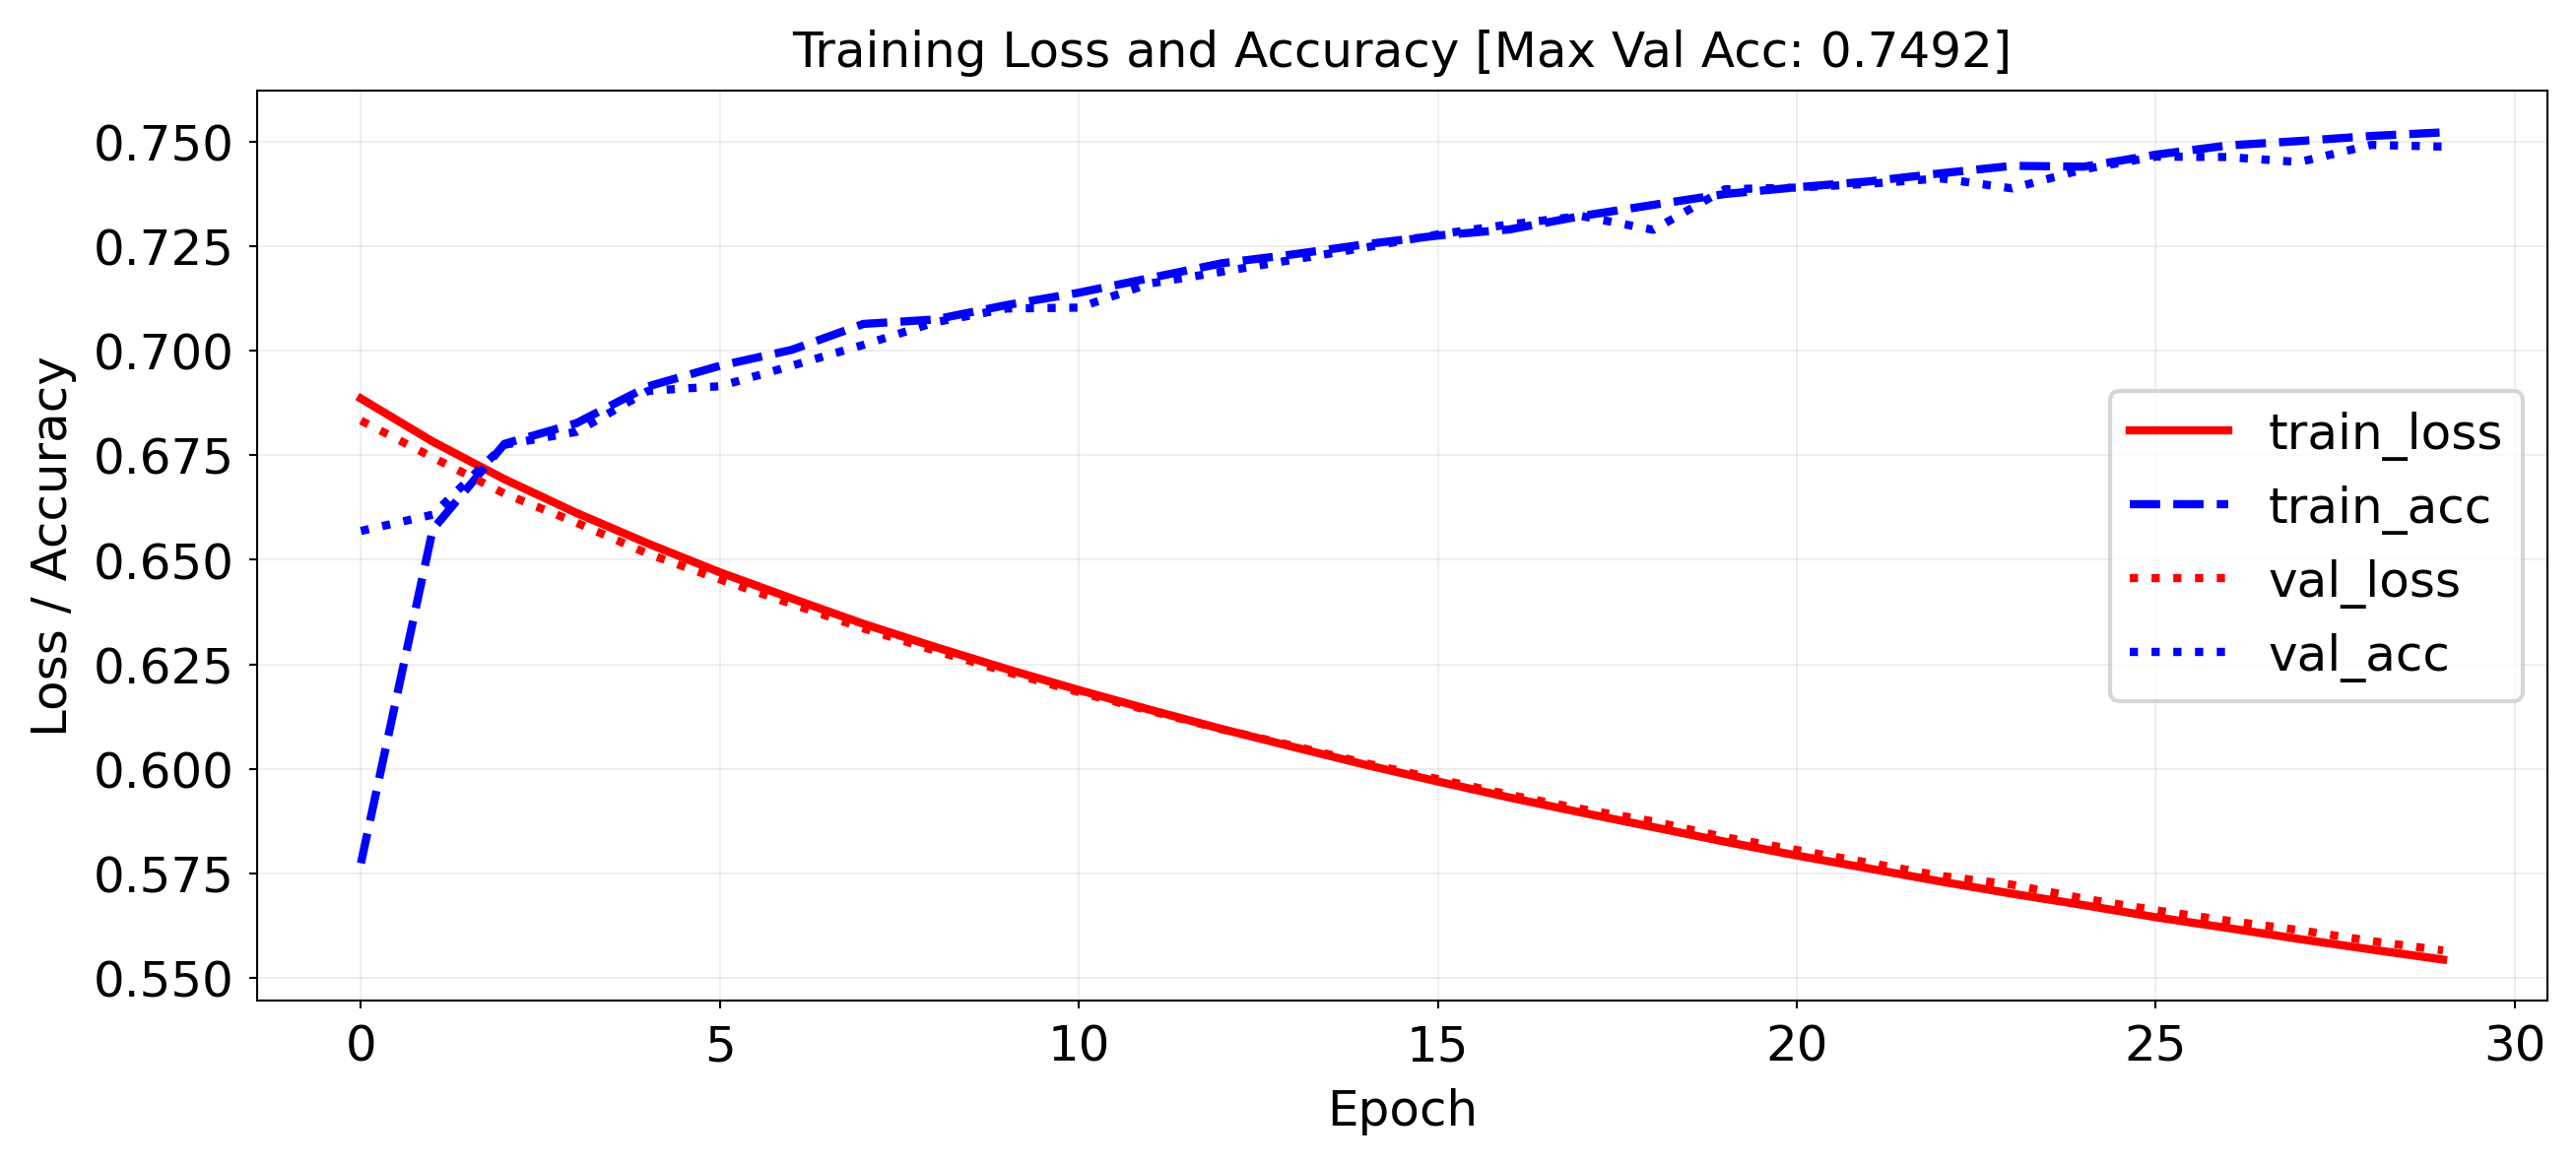

`Trainer.fit` stopped: `max_epochs=30` reached.


In [7]:
# Load GloVe (assumes file is like 'glove.6B.300d.txt')
embedding_dim = 300
glove_path = "../data/glove.txt"

embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
vocab_size = 10000
embedding_matrix = np.zeros((vocab_size, embedding_dim))
missing = 0

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            missing += 1

print(f"{missing} words not found in GloVe.")

class Permute(nn.Module):
    def __init__(self, *dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class Squeeze(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.squeeze(self.dim)

class FrozenGloVeModel(pl.LightningModule):
    def __init__(self, embedding_matrix, max_length=100):
        super().__init__()
        embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.model = nn.Sequential(
            nn.Embedding.from_pretrained(embedding_tensor, freeze=True),
            Permute(0, 2, 1),
            nn.AdaptiveAvgPool1d(1),
            Squeeze(dim=-1),
            nn.Linear(embedding_tensor.shape[1], 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.binary_cross_entropy(y_hat, y)
        val_acc = ((y_hat > 0.5) == y.bool()).float().mean()
        self.log("val_loss", val_loss, on_epoch=True)
        self.log("val_acc", val_acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
model = FrozenGloVeModel(embedding_matrix=embedding_matrix, max_length=100)

trainer = pl.Trainer(
    max_epochs=30,
    logger=False,
    enable_checkpointing=False,
    callbacks=[LivePlotCallback()]  # optional
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        
        
        
        
        
        

## Sequence-to-sequence (seq2seq) models
* Global average pooling or flattening destroys the word order
* We need to model sequences explictly, e.g.:
    * 1D convolutional models: run a 1D filter over the input data
        * Fast, but can only look at small part of the sentence
    * Recurrent neural networks (RNNs)
        * Can look back at the entire previous sequence
        * Much slower to train, have limited memory in practice
    * Attention-based networks (Transformers)
        * Best of both worlds: fast and very long memory

### seq2seq models
* Produce a series of output given a series of inputs over time
* Can handle sequences of different lengths
    * Label-to-sequence, Sequence-to-label, seq2seq,...
    * Autoregressive models (e.g. predict the next character, unsupervised)


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_seq2seq.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

### 1D convolutional networks
* Similar to 2D convnets, but moves only in 1 direction (time)
    * Extract local 1D patch, apply filter (kernel) to every patch
    * Pattern learned can later be recognized elsewhere (translation invariance)
* Limited memory: only sees a small part of the sequence (receptive field)
    * You can use multiple layers, dilations,... but becomes expensive
* Looks at 'future' parts of the series, but can be made to look only at the past
    * Known as 'causal' models (not related to causality)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_1dconv.png" alt="ml" style="width:100%;"/>

* Same embedding, but add 2 `Conv1D` layers and `MaxPooling1D`.
```python
model = nn.Sequential(
    nn.Embedding(num_embeddings=10000, embedding_dim=embedding_dim),
    nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=7),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=5),
    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(1),  # GAP
    nn.Flatten(),             # (batch, 32, 1) → (batch, 32)
    nn.Linear(32, 1)
)
```

In [8]:
model = nn.Sequential(
    nn.Embedding(num_embeddings=10000, embedding_dim=embedding_dim),  # embedding_layer
    nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=7),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=5),
    nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(1),  # equivalent to GlobalAveragePooling1D
    nn.Flatten(),             # flatten (batch, 32, 1) → (batch, 32)
    nn.Linear(32, 1),
    nn.Sigmoid()
)


### Recurrent neural networks (RNNs)
* Recurrent connection: concats output to next input
${\color{orange} h_t} = \sigma \left( {\color{orange} W } \left[ \begin{array}{c} {\color{blue}x}_t \\ {\color{orange} h}_{t-1} \end{array} \right] + b \right)$
* Unbounded memory, but training requires _backpropagation through time_
    * Requires storing previous network states (slow + lots of memory)
    * Vanishing gradients strongly limit practical memory
* Improved with _gating_: learn what to input, forget, output (LSTMs, GRUs,...)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_rnn.png" alt="ml" style="width:70%;"/>

### Simple self-attention
* Maps a _set_ of inputs to a set of outputs (_without_ learned weigths)


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/selfattention.png" alt="ml" style="width:50%;"/>

### Simple self-attention
* Compute dot product of input vector $x_i$ with every $x_j$ (including itself): ${\color{Orange} w_{ij}}$
* Compute softmax over all these weights (positive, sum to 1)
* Multiply by each input vector, and sum everything up
* Can be easily vectorized: ${\color{green} Y}^T = {\color{orange} W}{\color{blue} X^T}$, ${\color{orange} W} = \textrm{softmax}( {\color{blue} X}^T {\color{blue}X} )$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention.png" alt="ml" style="width:70%;"/>

* For each output, we mix information from all inputs according to how 'similar' they are
    * The set of weights ${\color{Orange} w_{i}}$ for a given token is called the attention vector
    * It says how much 'attention' each token gives to other tokens
* Doesn't learn (no parameters), the embedding of ${\color{blue} X}$ defines self-attention
    * We'll learn how to _transform the embeddings_ later
    * That way we can learn different relationships (not just similarity)
* Has no problem looking _very_ far back in the sequence
* Operates on _sets_ (permutation invariant): allows img-to-set, set-to-set,... tasks
    * If the token order matters, we'll have to encode it in the token embedding

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention.png" alt="ml" style="width:45%;"/>

### Scaled dot products
* Self-attention is powerful because it's mostly a linear operation
* ${\color{green} Y}^T = {\color{orange} W}{\color{blue} X^T}$ is _linear_, there are no vanishing gradients
    * The softmax function only applies to ${\color{orange} W} = \textrm{softmax}( {\color{blue} X}^T {\color{blue}X} )$, not to ${\color{green} Y}^T$
    * Needed to make the attention values sum up nicely to 1 without exploding
* The dot products do get larger as the embedding dimension $k$ gets larger (by a factor $\sqrt{k}$)
    * We therefore normalize the dot product by the input dimension $k$: ${\color{orange}w^{'}_{ij}} = \frac{{\color{blue} x_i}^T \color{blue} x_j}{\sqrt{k}}$
    * This also makes training more stable: large softmas values lead to 'sharp' outputs, making some gradients very large and others very small 
    


### Simple self-attention layer
* Let's add a simple self-attention layer to our movie sentiment model
* Without self-attention, every word would contribute independently (bag of words)
    * The word _terrible_ will likely result in a negative prediction
* Now, we can freeze the embedding, take output ${\color{gray}Y}$, obtain a loss, and do backpropagation so that the self-attention layer can _learn_ that 'not' should invert the meaning of 'terrible'

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_layer_train.png" alt="ml" style="width:40%;"/>

### Simple self-attention layer
* Through training, we want the self-attention to learn how certain tokens (e.g. 'not') can affect other tokens / words.
    * E.g. we need to learn to change the representations of $v_{not}$ and $v_{terrible}$ so that they produce a 'correct' (low loss) output
* For that, we do need to add some trainable parameters.

   

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_negation.png" alt="ml" style="width:50%;"/>

### Standard self-attention
* We add 3 weight matrices (K, Q, V) and biases to change each vector:
    * $k_i = K x_i + b_k$
    * $q_i = Q x_i + b_q$
    * $v_i = V x_i + b_v$
* The same K, Q, V are used for all tokens depending on whether they are the input token (v), the token we are currently looking at (q), or the token we're comparing with (k)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_kqv3.png" alt="ml" style="width:50%; margin-left: auto; margin-right: auto;"/>

### Sidenote on terminology
* View the set of tokens as a dictionary 
`s = {a: v_a, b: v_b, c: v_c}`
* In a dictionary, the third output (for key c) would simple be `s[c] = v_c`
* In a _soft_ dictionary, it's a weighted sum: $s[c] = w_a * v_a + w_b * v_b + w_c * v_c$
* If $w_i$ are dot products: $s[c] = (k_a\cdot q_c) * v_a + (k_b\cdot q_c) * v_b + (k_b\cdot q_c) * v_c$
* We _blend_ the influence of every token based on their learned relations with other tokens
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_kqv_dict.png" alt="ml" style="width:40%; margin-left: auto; margin-right: auto;"/>

### Intuition
* We _blend_ the influence of every token based on their learned 'relations' with other tokens
* Say that we need to learn how 'negation' works
    * The 'query' vector could be trained (via Q) to say something like 'are there any negation words?'
    * A token (e.g. 'not'), transformed by K, could then respond very positively if it is

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_kqv_not2.png" alt="ml" style="width:40%; margin-left: auto; margin-right: auto;"/>

### Single-head self-attention
* There are different relations to model within a sentence.
* The same input token, e.g. $v_{terrible}$ can relate completely differently to other kinds of tokens
    * But we only have one set of K, V, and Q matrices
* To better capture multiple relationships, we need multiple self-attention operations (expensive)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_properties.png" alt="ml" style="width:40%; margin-left: auto; margin-right: auto;"/>

### Multi-head self-attention
* What if we project the input embeddings to a lower-dimensional embedding $k$?
* Then we could learn multiple self-attention operations in parallel
* Effectively, we split the self-attention in multiple heads
    * Each applies a separate low-dimensional self attention (with $K^{kxk},Q^{kxk},V^{kxk}$)
* After running them (in parallel), we concatenate their outputs.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_multihead_attention.png" alt="ml" style="width:60%;"/>

## Transformer model
* Repeat self-attention multiple times in controlled fashion
* Works for sequences, images, graphs,... (learn how sets of objects interact)
* Models consist of multiple transformer blocks, usually:
    * Layer normalization (every input is normalized independently)
    * Self-attention layer (learn interactions)
    * Residual connections (preserve gradients in deep networks)
    * Feed-forward layer (learn mappings)
    

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_transformer_model.png" alt="ml" style="width:60%;"/>

### Positional encoding
* We need some way to tell the self-attention layer about position in the sequence
* Represent position by vectors, using some easy-to-learn predictable pattern
    * Add these encodings to vector embeddings
    * Gives information on how far one input is from the others
* Other techniques exist (e.g. relative positioning)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_encoding2.png" alt="ml" style="width:70%;"/>

### Autoregressive models

* Models that predict future values based on past values of the same stream
* Output token is mapped to list of probabilities, sampled with softmax (with temperature) 
* Problem: self-attention can simply look ahead in the stream
    * We need to make the transformer blocks _causal_

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_autoregressive2.png" alt="ml" style="width:60%; margin-left: auto; margin-right: auto;"/>

### Masked self-attention
* Simple solution: simply mask out any attention weights from current to future tokens 
* Replace with -infinity, so that after softmax they will be 0


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_maskedse.png" alt="ml" style="width:60%; margin-left: auto; margin-right: auto;"/>

### Famous transformers
* "Attention is all you need": first paper to use attention without CNNs or RNNs
* Encoder-Decoder architecture for translation: (k, q) to source attention layer 
* We'll reproduce this (partly) in the Lab 6 tutorial :)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_aiayn.png" alt="ml" style="width:40%; margin-left: auto; margin-right: auto;"/>

### GPT 3
* Decoder-only, single stack of 96 transformer blocks (and 96 heads)
* Sequence size 2048, input dimensionality 12,288, 175B parameters
* Trained on entire common crawl dataset (1 epoch)
    * Additional training on high-quality data (Wikipedia,...)
* [Excellent animation by 1b3b](https://youtu.be/wjZofJX0v4M?t=305)
* [GPT from scratch by A. Karpathy](https://www.youtube.com/watch?v=kCc8FmEb1nY)


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_gpt.png" alt="ml" style="width:40%; margin-left: auto; margin-right: auto;"/>

### GPT 4
* Likely a 'mixtures of experts' model
    * Router (small MLP) selects which subnetworks (e.g. 2) to use given input
    * Predictions get ensembled
* Allows scaling up parameter count without proportionate (inference) cost
* Also better data, more human-in-the-loop training (RLHF),...

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_switch_transformer2.png" alt="ml" style="width:60%; margin-left: auto; margin-right: auto;"/>


## Vision transformers
* Same principle: split up into patches, embed into tokens, add position encoding
* For classification: add an extra (random) input token -> [CLS] output token
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/vit.gif" alt="ml" style="width:70%;"/>

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
print("Device:", device)

DATASET_PATH = "../data"
CHECKPOINT_PATH = "../data/checkpoints"

Device: mps


### Demonstration

We'll experiment with the CIFAR-10 datasets
* ViTs are quite expensive on large images.
* This ViT takes about an hour to train (we'll run it from a checkpoint)

In [10]:
pl.seed_everything(42)

Seed set to 42


42

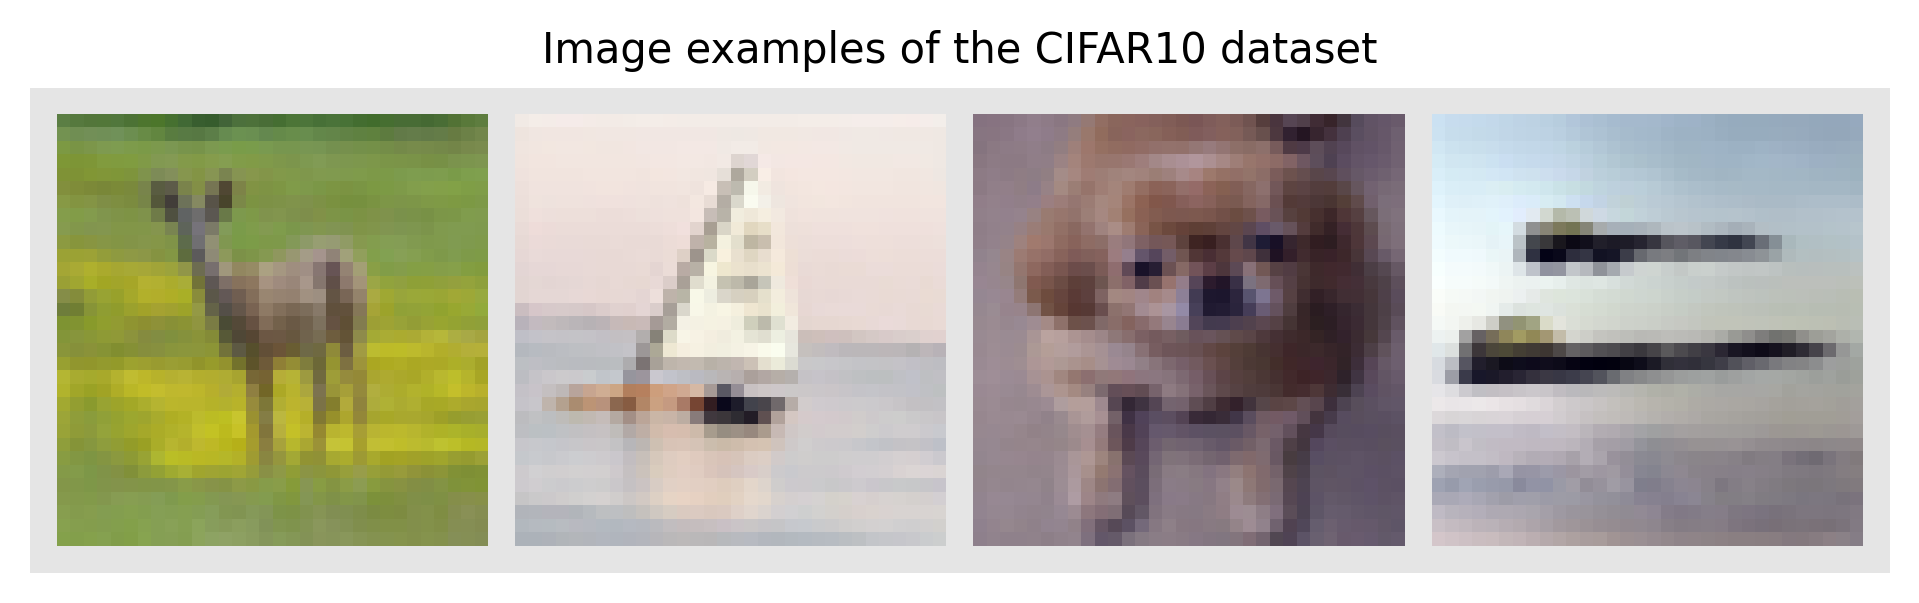

In [39]:
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import multiprocessing
import copy

# Define normalization constants for CIFAR-10
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2470, 0.2435, 0.2616]

# Define transforms. Using Auto-Augment
train_transform = transforms.Compose([
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])
# More aggressive, to reduce overfitting
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Load the full dataset once
full_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
train_set, val_set = torch.utils.data.random_split(full_dataset, [45000, 5000])

# Apply different transforms to each split
train_set.dataset = copy.deepcopy(full_dataset)
train_set.dataset.transform = train_transform

val_set.dataset = copy.deepcopy(full_dataset)
val_set.dataset.transform = test_transform

# Load the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Optimized DataLoader settings
pin_memory = torch.cuda.is_available()
num_workers = multiprocessing.cpu_count()  # or set manually, e.g., 8

train_loader = data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=pin_memory,
    num_workers=num_workers,
    persistent_workers=True,
    prefetch_factor=4
)

val_loader = data.DataLoader(
    val_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    pin_memory=pin_memory,
    num_workers=num_workers,
    persistent_workers=True,
    prefetch_factor=4
)

test_loader = data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    pin_memory=pin_memory,
    num_workers=num_workers,
    persistent_workers=True,
    prefetch_factor=4
)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset", fontsize=10)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Patchify
*  Split $N\times N$ image into $(N/M)^2$ patches of size $M\times M$.
```python
    B, C, H, W = x.shape  # Batch size, Channels, Height, Width
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
```

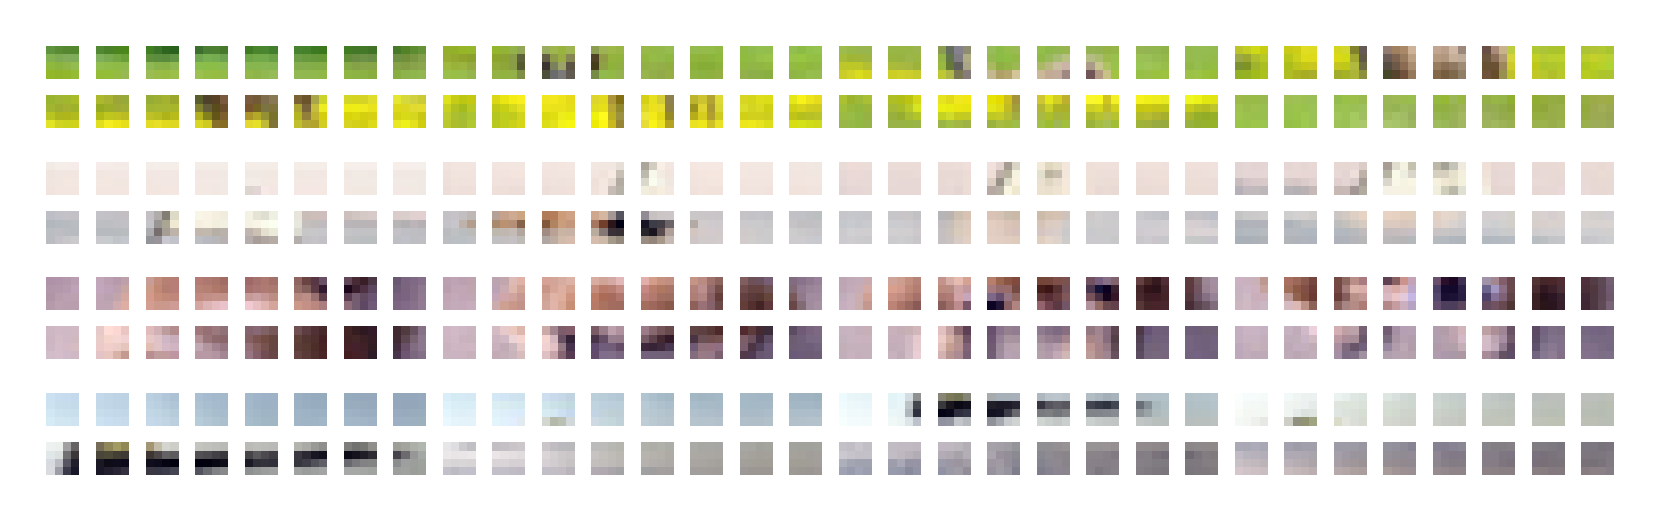

In [40]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 2))
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=32, normalize=True, pad_value=1)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')

plt.subplots_adjust(hspace=0)  # Reduce vertical spacing between rows
plt.show()
plt.close()

### Self-attention
First, we need to implement a (scaled) dot-product

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/scaled_dot_product_attn.svg" alt="ml" style="width:20%; margin-left: auto; margin-right: auto;"/>

### Self-attention
First, we need to implement a (scaled) dot-product
```python
def scaled_dot_product(q, k, v):
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # dot prod
    attn_logits = attn_logits / math.sqrt(q.size()[-1])# scaling
    attention = F.softmax(attn_logits, dim=-1)         # softmax
    values = torch.matmul(attention, v)                # dot prod
    return values, attention
```

In [13]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

### Multi-head attention (simplified)
* Project input to lower-dimensional embeddings
* Stack them so we can feed them through self-attention at once
* Unstack and project back to original dimensions

``` python        
    qkv = nn.Linear(input_dim, 3*embed_dim)(x) # project to embed_dim
    qkv = qkv.reshape(batch_size, seq_length, num_heads, 3*head_dim)
    q, k, v = qkv.chunk(3, dim=-1) 

    values, attention = scaled_dot_product(q, k, v, mask=mask) # self-att
    values = values.reshape(batch_size, seq_length, embed_dim)
    out = nn.Linear(embed_dim, input_dim) # project back
```

In [14]:
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

### Attention block
The attention block is quite straightforward

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_attention_layer.png" alt="ml" style="width:35%; margin-left: auto; margin-right: auto;"/>

### Attention block
```python
def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
    self.layer_norm_1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads)
    self.layer_norm_2 = nn.LayerNorm(embed_dim)
    self.linear = nn.Sequential( # Feed-forward layer
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU(), nn.Dropout(dropout),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout)
    )
```
```python
def forward(self, x):
    inp_x = self.layer_norm_1(x)
    x = x + self.attn(inp_x, inp_x, inp_x)[0] # self-att + res
    x = x + self.linear(self.layer_norm_2(x)) # feed-fw + res
    return x
```

In [15]:
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, 
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
        
    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

## Vision transformer
Final steps: 
* Linear projection (embedding) to map patches to vector
* Add classification token to input
* 2D positional encoding
* Small MLP head to map CLS token to prediction


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_vit.png" alt="ml" style="width:50%; margin-left: auto; margin-right: auto;"/>

### Positional encoding
* We implement this pattern and run in across a 2D grid:
$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$


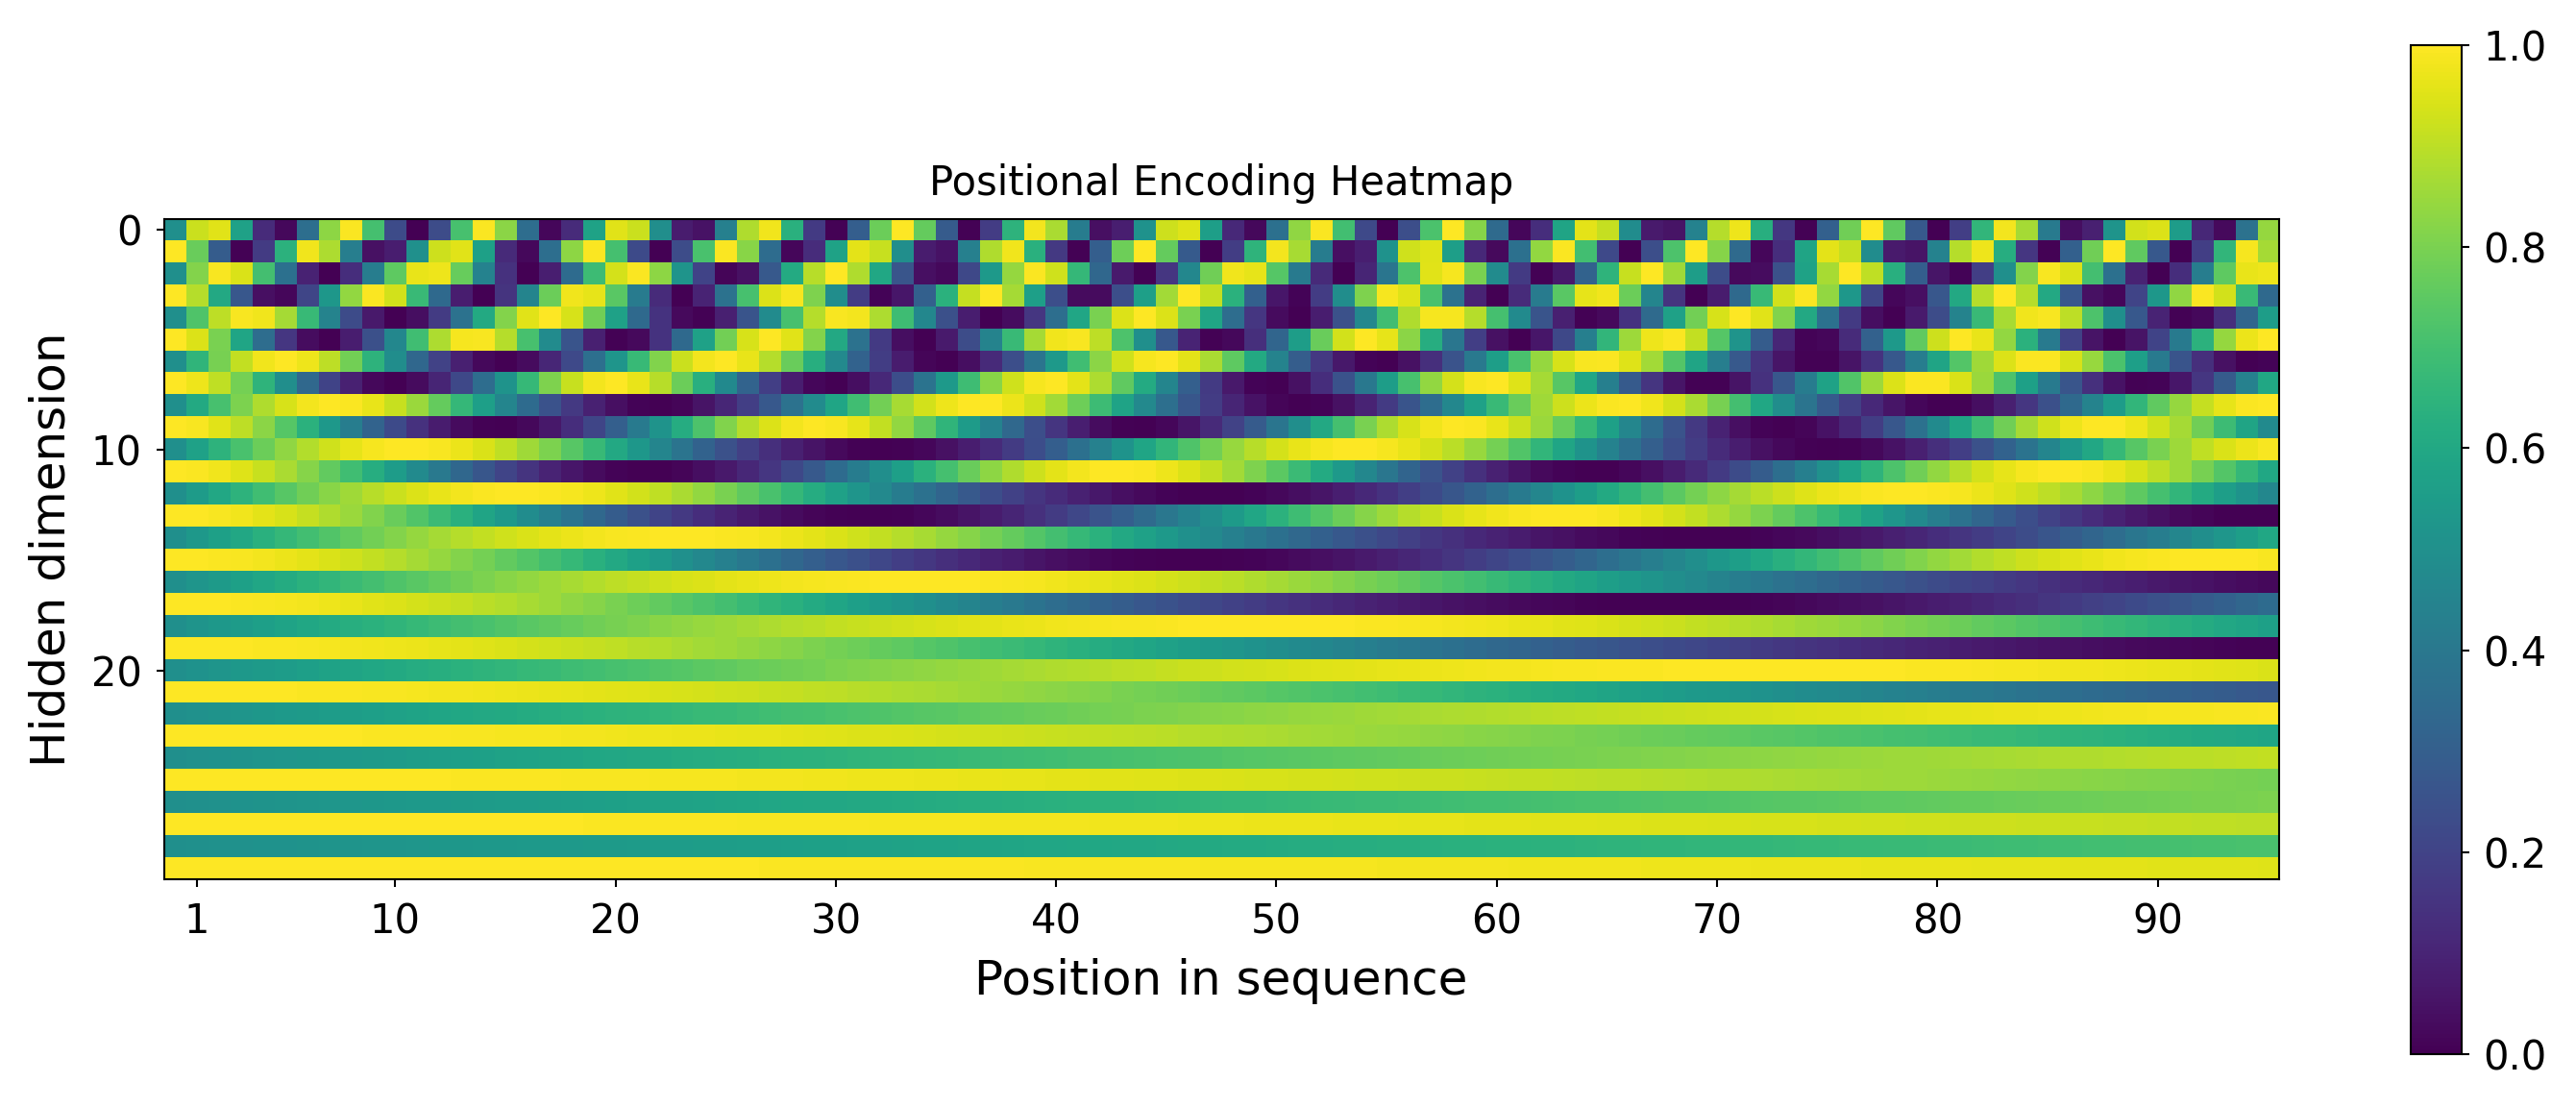

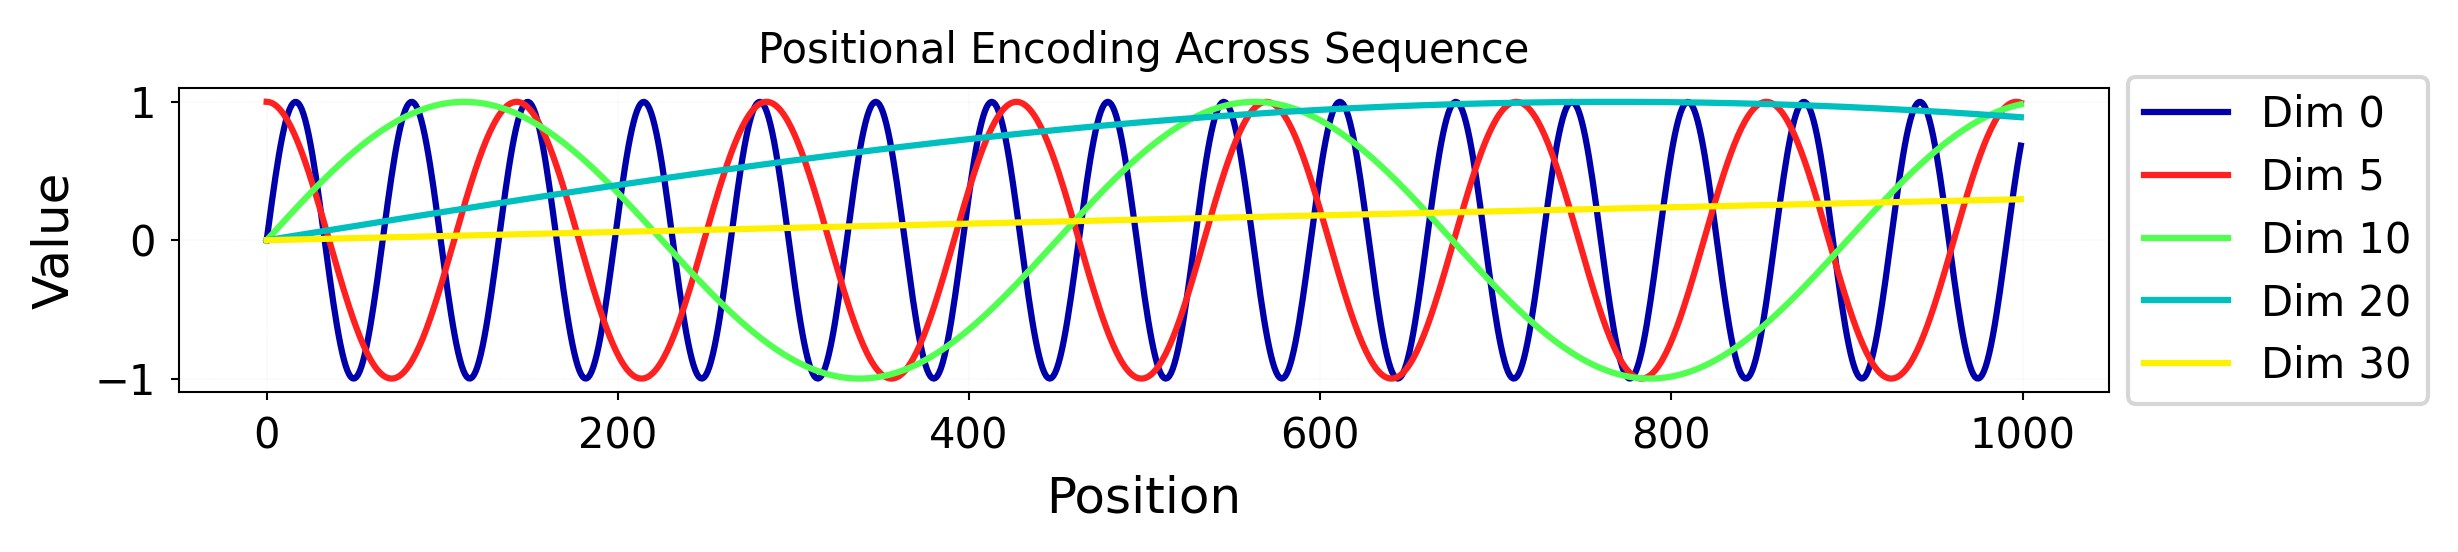

In [51]:
from sklearn.preprocessing import MinMaxScaler
import math

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 1.5
})

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Create positional encoding
d_model = 48
max_len = 96
encod_block = PositionalEncoding(d_model=d_model, max_len=max_len)
pe = encod_block.pe.squeeze().T.cpu().numpy()  # Shape: [d_model, max_len]

# Global normalization
pe_subset = pe[:30]
pe_norm = (pe_subset - pe_subset.min()) / (pe_subset.max() - pe_subset.min())

# Plot heatmap with global normalization
fig, ax = plt.subplots(figsize=(10, 4))
img = ax.imshow(pe_norm, cmap="viridis")
fig.colorbar(img, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional Encoding Heatmap")
ax.set_xticks([1] + [i*10 for i in range(1, 1 + pe.shape[1]//10)])
ax.set_yticks(np.arange(0, 30, 10))
ax.set_yticklabels([str(i) for i in range(0, 30, 10)])
plt.tight_layout()
plt.show()

# Smooth 1D plot for selected dimensions
high_res_positions = torch.linspace(0, max_len - 1, steps=1000).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
pe_highres = torch.zeros((1000, d_model))
pe_highres[:, 0::2] = torch.sin(high_res_positions * div_term)
pe_highres[:, 1::2] = torch.cos(high_res_positions * div_term)
pe_highres_np = pe_highres.T.cpu().numpy()

plt.figure(figsize=(10, 2))
for i in [0, 5, 10, 20, 30]:
    plt.plot(pe_highres_np[i], linestyle='-', label=f"Dim {i}")
plt.title("Positional Encoding Across Sequence")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [52]:
class VisionTransformer(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
        """
        super().__init__()
        
        self.patch_size = patch_size
        
        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    
    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)
        
        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [53]:
class ViT(pl.LightningModule):
    
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]   
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")
        
from torchvision.models import resnet18

class ResNet18Classifier(pl.LightningModule):
    def __init__(self, num_classes, lr):
        super().__init__()
        self.save_hyperparameters()
        base_model = resnet18(weights=None)
        in_features = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )
        self.model = base_model
        self.example_input_array = next(iter(train_loader))[0]
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]
    
    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.cross_entropy(preds, labels, label_smoothing=0.1)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

from matplotlib.cm import get_cmap
from IPython.display import display, update_display

class LiveCompareCallback(pl.Callback):
    def __init__(self, history, model_name):
        self.history = history
        self.model_name = model_name
        self.max_val_acc = 0
        self.display_id = None  # For live plot replacement
        self.display_handle = None

        if "_colors" not in self.history:
            self.history["_colors"] = {}
        if model_name not in self.history["_colors"]:
            cmap = plt.get_cmap("tab10")
            color_idx = len(self.history["_colors"])
            self.history["_colors"][model_name] = cmap(color_idx % 10)

        if model_name not in self.history:
            self.history[model_name] = {
                "train_loss": [],
                "train_acc": [],
                "val_loss": [],
                "val_acc": []
            }

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss")
        train_acc = metrics.get("train_acc")
        val_loss = metrics.get("val_loss")
        val_acc = metrics.get("val_acc")

        if all(v is not None for v in [train_loss, train_acc, val_loss, val_acc]):
            self.history[self.model_name]["train_loss"].append(train_loss.item())
            self.history[self.model_name]["train_acc"].append(train_acc.item())
            self.history[self.model_name]["val_loss"].append(val_loss.item())
            self.history[self.model_name]["val_acc"].append(val_acc.item())
            self.max_val_acc = max(self.max_val_acc, val_acc.item())
            self.plot_all_models()

    def plot_all_models(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for model_name, logs in self.history.items():
            if model_name == "_colors":
                continue
            color = self.history["_colors"][model_name]
            epochs = range(len(logs["train_loss"]))

            axes[0].plot(epochs, logs["train_loss"], label=f'{model_name} Train', linestyle='-', color=color)
            axes[0].plot(epochs, logs["val_loss"], label=f'{model_name} Val', linestyle=':', color=color)

            axes[1].plot(epochs, logs["train_acc"], label=f'{model_name} Train', linestyle='-', color=color)
            axes[1].plot(epochs, logs["val_acc"], label=f'{model_name} Val', linestyle=':', color=color)

        axes[0].set_title("Loss", fontsize=10)
        axes[1].set_title("Accuracy", fontsize=10)
        for ax in axes:
            ax.set_xlabel("Epoch", fontsize=10)
            ax.grid(True)
            ax.legend()
        axes[0].set_ylabel("Loss", fontsize=10)
        axes[1].set_ylabel("Accuracy", fontsize=10)
        plt.suptitle("Model Comparison", fontsize=14)
        plt.tight_layout()

        # Display once, then update in-place
        if self.display_handle is None:
            self.display_handle = display(fig, display_id=True)
        else:
            self.display_handle.update(fig)

        plt.close(fig)

In [54]:
def train_model(model_class, model_name, model_kwargs, lr, history):
    model_ckpt_path = os.path.join(CHECKPOINT_PATH, model_name)
    pretrained_filename = os.path.join(model_ckpt_path, f"{model_name}.ckpt")

    callback = LiveCompareCallback(history=history, model_name=model_name)

    trainer = pl.Trainer(
        default_root_dir=model_ckpt_path,
        accelerator="auto",
        devices=1,
        max_epochs=50,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
            callback
        ],
        logger=pl.loggers.TensorBoardLogger(save_dir=model_ckpt_path, name=model_name)
    )

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = model_class(**model_kwargs, lr=lr)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)

    return model, {
        "val": val_result[0]["test_acc"],
        "test": test_result[0]["test_acc"]
    }

### Results
* ResNet outperforms ViT!
* Inductive biases of CNNs win out if you have limited data/compute
* Transformers have very little inductive bias
    * More flexible, but also more data hungry

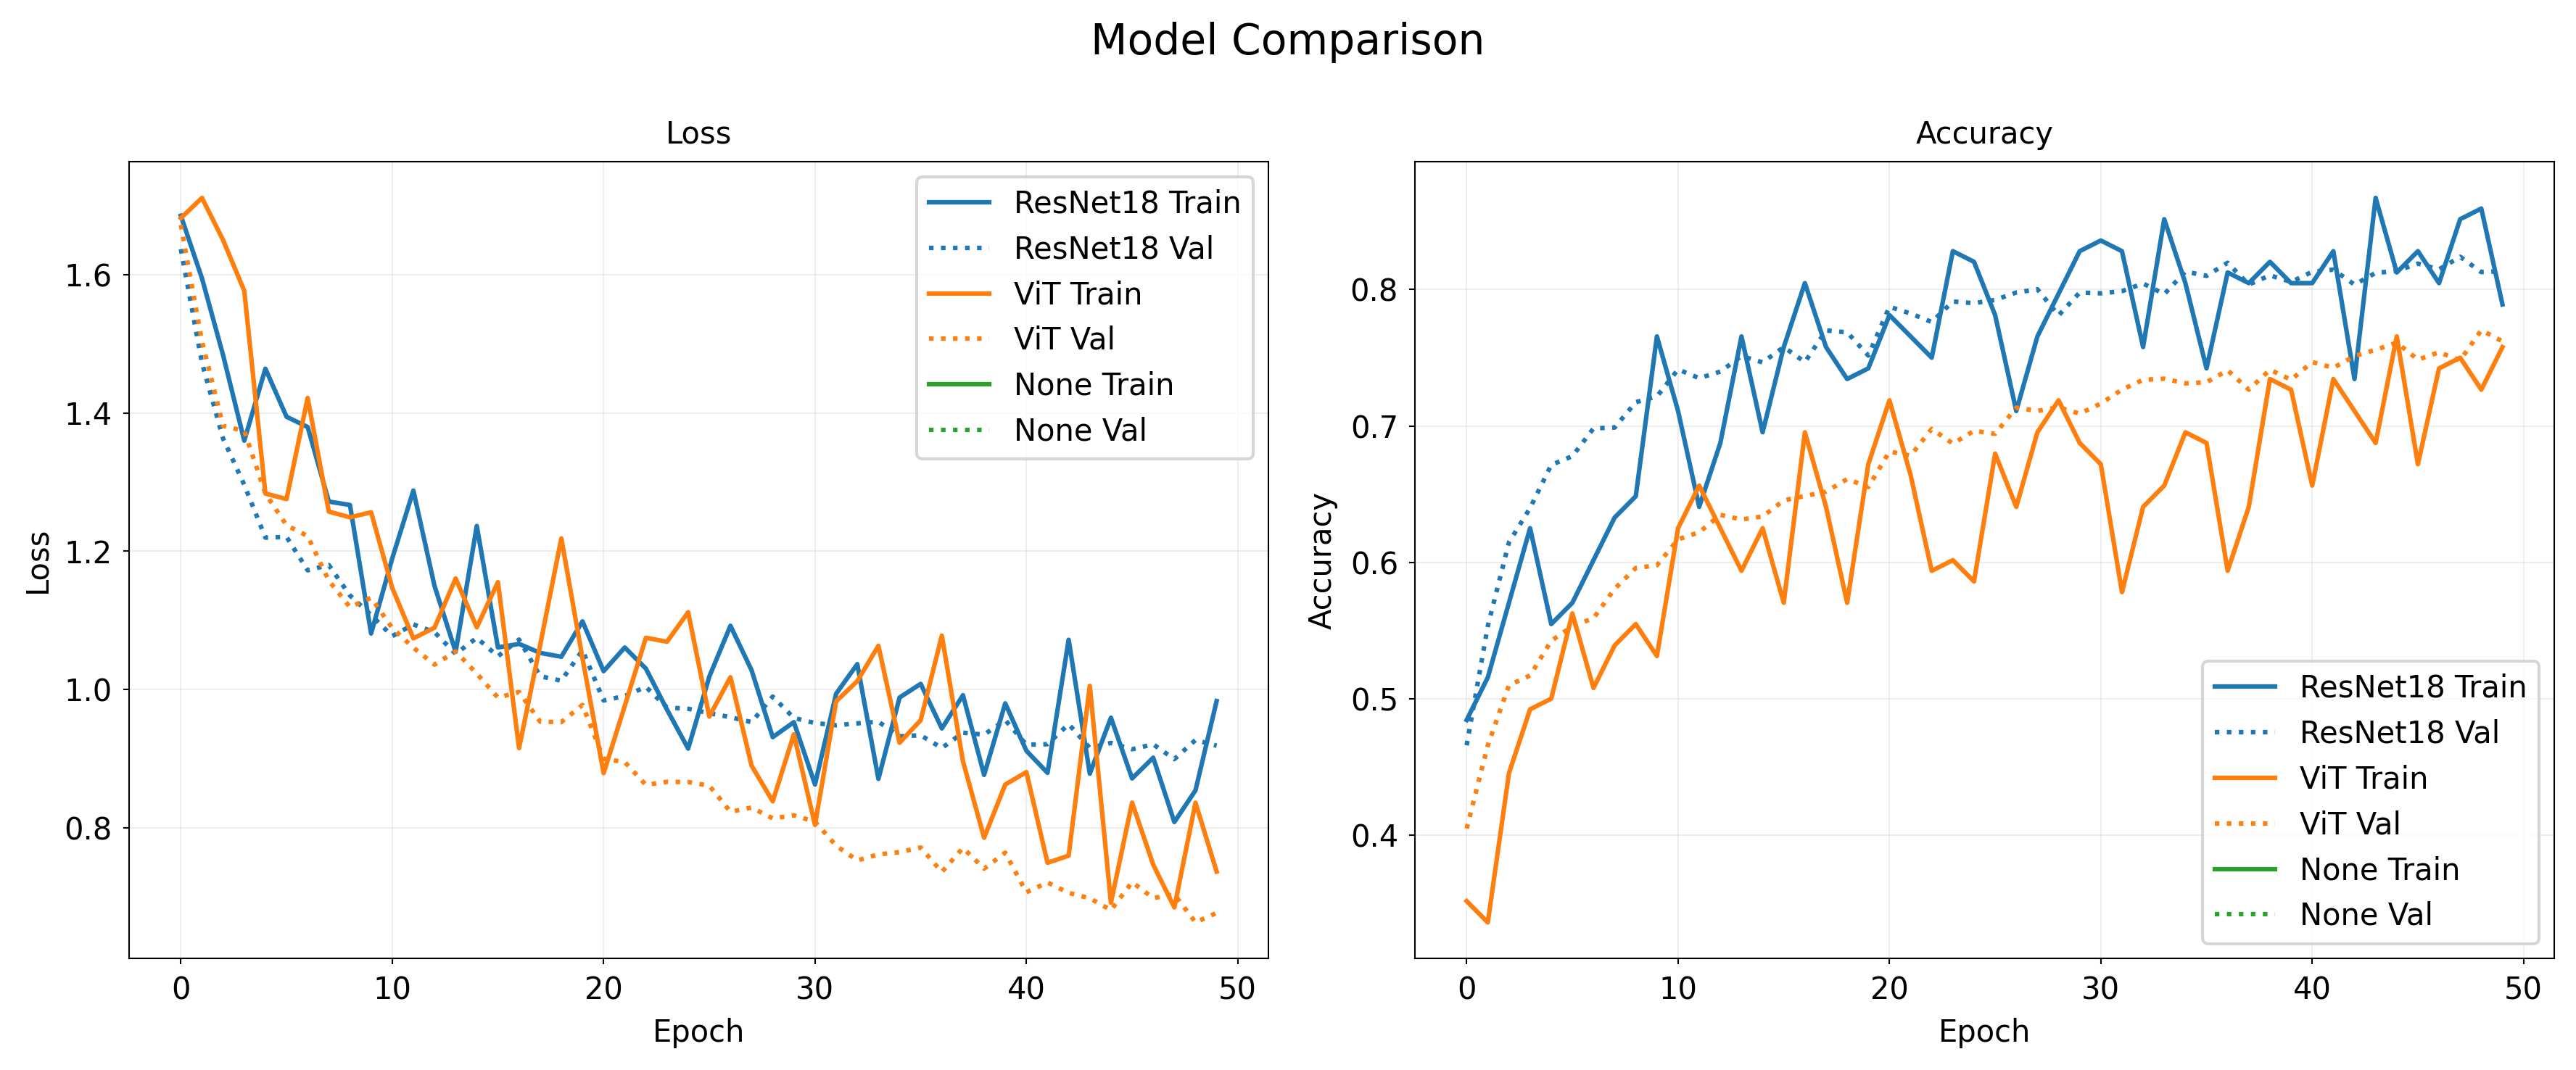

In [58]:
with open("../data/vit_histories.pkl", "rb") as f:
    histories = pickle.load(f)

if "vit" in histories:
    lccb = LiveCompareCallback(histories["vit"], None)
    lccb.plot_all_models()
else: 
    vit_kwargs={'embed_dim': 256,
                'hidden_dim': 512,
                'num_heads': 8,
                'num_layers': 6,
                'patch_size': 4,
                'num_channels': 3,
                'num_patches': 64,
                'num_classes': 10,
                'dropout': 0.2}

    history = {}

    resnet_model, resnet_results = train_model(
        model_class=ResNet18Classifier,
        model_name="ResNet18",
        model_kwargs={"num_classes": 10},
        lr=3e-4,
        history=history
    )

    vit_model, vit_results = train_model(
        model_class=ViT,
        model_name="ViT",
        model_kwargs={"model_kwargs": vit_kwargs},
        lr=3e-4,
        history=history
    )

In [56]:
# Store history
import pickle 

if "vit" not in histories:
    histories = {"vit":history}
    with open("../data/vit_histories.pkl", "wb") as f:
        pickle.dump(histories, f)

## Summary
* Tokenization
    * Find a good way to split data into tokens
* Word/Image embeddings (for initial embeddings)
    * For text: Word2Vec, FastText, GloVe
    * For images: MLP, CNN,...
* Sequence-to-sequence models
    * 1D convolutional nets (fast, limited memory)
    * RNNs (slow, also quite limited memory)
* Transformers
    * Self-attention (allows very large memory)
    * Positional encoding
    * Autoregressive models
* Vision transformers
    * Useful if you have lots of data (and compute)

Acknowledgement

Several figures came from the excellent [VU Deep Learning course](https://dlvu.github.io/).